<center> <h1>HYPERSPECTRAL DATA CLASSIFICATION UNSING CNN </h1> </center>



In [1]:
import numpy as np
from scipy.io import loadmat
import pylab as pl

import matplotlib.pyplot as plt
%matplotlib inline

## Load data


In [2]:
PAVIA_PATH = '../pavia.npy'
PAVIA_VT_PATH = '../train_set.npy'

In [3]:
pavia = np.load(PAVIA_PATH)
print(pavia.shape)

(610, 340, 103)


**Visualisation**

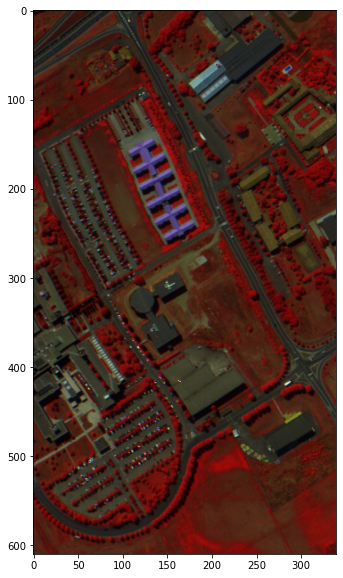

In [4]:

nbands=[100,50,10]

pl.figure(figsize=(10,10))
pl.imshow(pavia[:,:,nbands])
pl.show()

**Loading labeled data**

In [5]:
pavia_vt = np.load(PAVIA_VT_PATH)

pavia_vt shape: (610, 340)


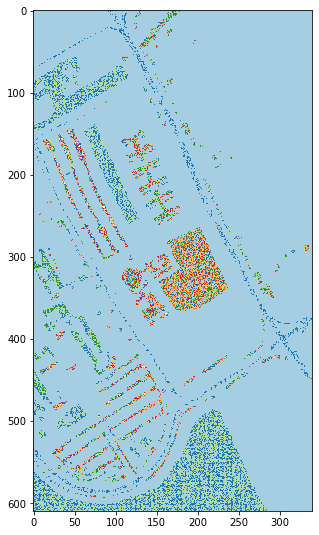

In [6]:
print(f'pavia_vt shape: {pavia_vt.shape}')
#print(pavia_vt)

pl.figure(figsize=(5,10))
pl.imshow(pavia_vt,cmap='Paired')
pl.show()

## Dimension reduction

**Why reduce dimensions?**
The first version of this work where using the $103$ bands for classification. This made us come up with a very huge matrix $(610, 340, 8, 8, 103)$ for a patch of $8$, what quickly overfill the memory.

A solution is to reduce the depth dimension through Principal Component Analysis.

### Standardization


**Standardization (mean removal and variance scaling)**

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
m, n, p = pavia.shape
pavia_std = scaler.fit_transform(pavia.reshape(-1, p))

In [8]:
pavia_std.shape

(207400, 103)

In [9]:
print(pavia_std.min(), pavia_std.max())

-2.9051585338913153 15.168407577215131


**Apply PCA**

In [10]:
from sklearn.decomposition import PCA

N_COMP = 10
pca = PCA(n_components=N_COMP)
pca.fit(pavia_std)

#percentage of variation
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
print(per_var)


[64.6 28.5  5.2  0.5  0.3  0.2  0.2  0.1  0.1  0.1]


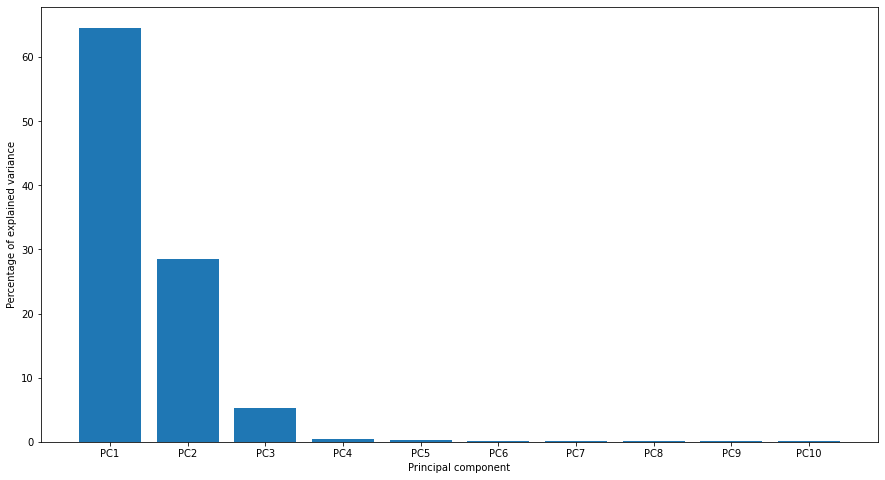

In [11]:
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
#ploting
plt.figure(figsize=(15, 8))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.xlabel('Principal component')
plt.ylabel('Percentage of explained variance')
plt.show()

>**Remark:**
Almost all the variation is along the ten first PC. A reconstruction using only those PC's will represent the original data.

In [12]:
pavia_pca = pca.transform(pavia_std).reshape(m, n, N_COMP)
pavia_pca.shape

(610, 340, 10)

## Image patches

The images patches feed into the network will be of size $P*P$ pixels.
The idea is :
Giving a pixel at a position in the original image, we'll create an image with the chosen pixel centered(or not really, depending on if the patch sizes are odd or even) in this new Image and the other pixels will be the  closest one (in term of distance) from the original image.
For simplicity we choose a square patch.

In [13]:
#
PATCH_SIZE = 12

### Padding

**Determine the axis pad width**

A 2-tuple of ints, axis_pad_width[0] represents the number of values padded at the beginning of vector where axis_pad_width[1] represents the number of values padded at the end of vector.

In [14]:
def get_pad_width(patch_size = PATCH_SIZE):
    pad_width = ( (patch_size-1)//2, (patch_size-1)//2) if (patch_size % 2 != 0) else ((patch_size-1)//2, (patch_size-1)//2 + 1)
    return pad_width

In [15]:
get_pad_width()

(5, 6)

In [16]:
"""Quick test for the padding logic

A = np.empty((5, 4, 3))
#modifying just a cell for later test
A[0, 0] = [-1, -2, -3]

pad_width = get_pad_width()

# apply padding
AA = np.pad(A, (pad_width, pad_width, (0, 0)), 'constant')

print(AA.shape)
print(AA[0, 0] == [0, 0, 0]) 
print(AA[3, 3] == [-1, -2, -3])
"""

"Quick test for the padding logic\n\nA = np.empty((5, 4, 3))\n#modifying just a cell for later test\nA[0, 0] = [-1, -2, -3]\n\npad_width = get_pad_width()\n\n# apply padding\nAA = np.pad(A, (pad_width, pad_width, (0, 0)), 'constant')\n\nprint(AA.shape)\nprint(AA[0, 0] == [0, 0, 0]) \nprint(AA[3, 3] == [-1, -2, -3])\n"

In [17]:
# get the shape of the padding
pad_width = get_pad_width()
# apply padding
padded_pavia = np.pad(pavia_pca, (pad_width, pad_width, (0, 0)) )
print(f'pavia shape after padding {padded_pavia.shape}') 

pavia shape after padding (621, 351, 10)


*Create the Images Patche*

In [18]:
p = N_COMP
patched_pavia = np.zeros((m, n, PATCH_SIZE, PATCH_SIZE, p))

In [19]:
print(patched_pavia[0, 0].shape)

(12, 12, 10)


In [20]:
LEFT_L, RIGHT_L = pad_width

row_start = col_start = LEFT_L;
row_end = m + LEFT_L #
col_end = n + LEFT_L

print(f'Will go from ({row_start}, {col_start}, ) to ({row_end-1}, {col_end-1}, )')

ii = 0; jj = 0 # start position indices in the on construction patched image
for i in range(row_start, row_end):
    for j in range(col_start, col_end):
        patched_pavia[ii, jj] = padded_pavia[i-LEFT_L: i+RIGHT_L+1, j-LEFT_L: j+RIGHT_L+1]
        #
        jj=jj+1
    jj = 0    
    ii=ii+1

Will go from (5, 5, ) to (614, 344, )


In [ ]:
"""# quick check out
# in this case PATCH_SIZE = 8
print(patched_pavia[1, 2].shape)
print(padded_pavia[1:9, 2:10].shape)

#patched_pavia[1, 2] == padded_pavia[1:9, 2:10]
np.all(patched_pavia[1, 2] == padded_pavia[1:9, 2:10])
"""

## Preprocessing data

### Normalize pixel data

The value of each component in a pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. 
So here we create a normalization function

In [21]:
def normalize(image):
    image = image.astype(np.float32)
    image = image - image.min()
    image /= image.max()
    return image

#X = normalize(patched_pavia) 
X = patched_pavia
#print(X)

### Filtering data

Retrieve useful data from the dataset

In [22]:
# seperating data
X1 = X[pavia_vt != 0]
y1 = pavia_vt[pavia_vt !=0 ]

In [23]:
print(f'[LABELED DATASET SIZE]: X1: {X1.shape}; y1: {y1.shape}' )

[LABELED DATASET SIZE]: X1: (21385, 12, 12, 10); y1: (21385,)


### Split data into train, test data

In [24]:
from sklearn.model_selection import train_test_split


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

**Valaidation set**

Get $10\%$ of Train dataset as validation set

In [26]:
#Didn't do it 
#Will be using validation_split argument inside the fit method

### One-hot encoding
 We convert integer-encoded categorical values as one-hot encoded values.

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [28]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

# summary
print(f'X_train shape : {X_train.shape}; Y_train shape: {Y_train.shape}')
print(f'X_test shape : {X_test.shape}; Y_test shape: {Y_test.shape}')

X_train shape : (17108, 12, 12, 10); Y_train shape: (17108, 10)
X_test shape : (4277, 12, 12, 10); Y_test shape: (4277, 10)


## Model Creation

In [29]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import initializers
from keras import callbacks

import time

In [30]:
K = Y_train.shape[1] #

#some initializers
initializer_1 = initializers.RandomNormal(stddev=0.01)

model = Sequential()

model.add(Conv2D(32, (6,6), padding='same', input_shape=X_train.shape[1:], activation='relu', kernel_initializer=initializer_1))
model.add(MaxPooling2D(pool_size=(2, 2) ))

model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer = initializer_1))

model.add(Dropout(0.2))
model.add(Dense(K, activation='softmax'))


In [31]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.002),
    metrics=['accuracy']
)

In [32]:
# This callback will stop the training when there is no improvement in  
# the validation accuracy for three consecutive epochs. 
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta= 0.002, 
    patience=3, restore_best_weights= True
)

In [33]:
# custom callback to monitor the  accuracy on validation data
class ValAccuracyCallback(callbacks.Callback):
    
    def __init__(self, threshold):
        super(ValAccuracyCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_accuracy = logs["val_accuracy"]
        if val_accuracy >= self.threshold:
            self.model.stop_training = True

**Training**

In [34]:
val_acc_callback=ValAccuracyCallback(threshold=1.00)
lr_callback = callbacks.ReduceLROnPlateau(patience=5, factor=0.4)

EPOCH = 200; BATCH_SIZE = 32


history = model.fit(
    X_train, Y_train, 
    validation_split=0.1,
    batch_size = BATCH_SIZE,
    epochs=EPOCH, 
    callbacks=[val_acc_callback, lr_callback]
)

Epoch 1/200
482/482 [==============================] - 17s 36ms/step - loss: 0.3314 - accuracy: 0.8841 - val_loss: 0.0711 - val_accuracy: 0.9784
Epoch 2/200
482/482 [==============================] - 21s 44ms/step - loss: 0.1412 - accuracy: 0.9671 - val_loss: 0.0991 - val_accuracy: 0.9696
Epoch 3/200
482/482 [==============================] - 21s 44ms/step - loss: 0.0448 - accuracy: 0.9874 - val_loss: 0.0785 - val_accuracy: 0.9860
Epoch 4/200
482/482 [==============================] - 21s 43ms/step - loss: 0.0912 - accuracy: 0.9793 - val_loss: 0.0289 - val_accuracy: 0.9906
Epoch 5/200
482/482 [==============================] - 13s 26ms/step - loss: 0.1365 - accuracy: 0.9775 - val_loss: 0.1706 - val_accuracy: 0.9603
Epoch 6/200
482/482 [==============================] - 21s 43ms/step - loss: 0.0738 - accuracy: 0.9898 - val_loss: 0.0171 - val_accuracy: 0.9953
Epoch 7/200
482/482 [==============================] - 21s 45ms/step - loss: 0.0354 - accuracy: 0.9918 - val_loss: 0.0182 - val_ac

### Training and validation graph

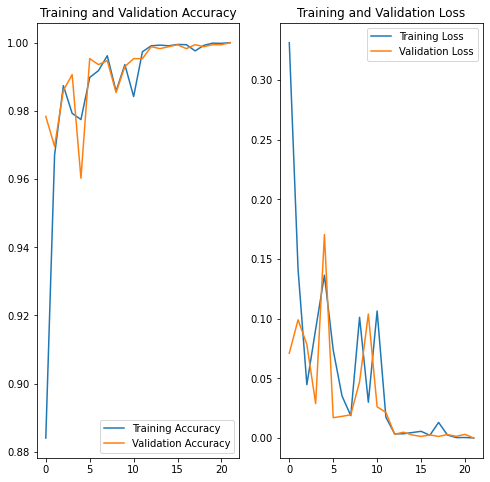

In [35]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Evaluation

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print('Accuracy on test dataset:', test_accuracy)

134/134 [==============================] - 1s 4ms/step - loss: 1.8597e-05 - accuracy: 1.0000
Accuracy on test dataset: 1.0


**Predictions**

In [37]:
m, n, p, q, r = X.shape
X_vectorized = X.reshape(-1, p, q, r)
print(X_vectorized.shape)

(207400, 12, 12, 10)


In [38]:
predictions = model.predict(X_vectorized)
print(predictions.shape)

(207400, 10)


In [39]:
pavia_predict = np.argmax(predictions, axis=1).reshape(610, 340)
print(pavia_predict.shape)

(610, 340)


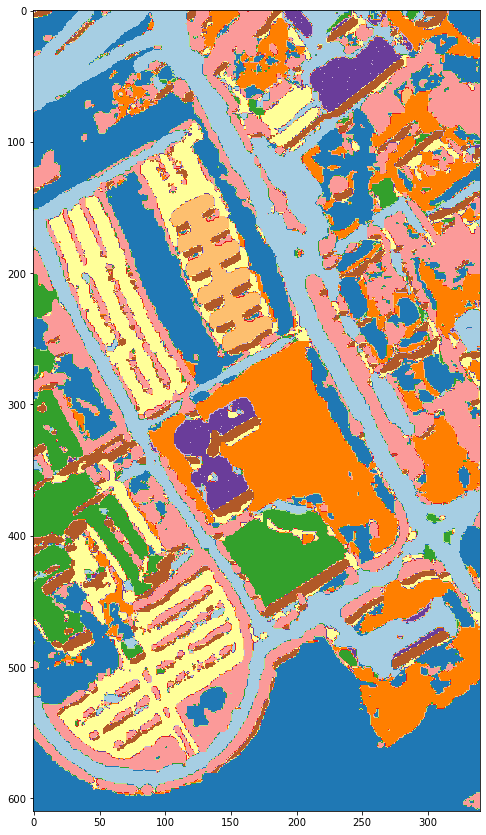

In [40]:
pl.figure(figsize=(8,16))
pl.imshow(pavia_predict,cmap='Paired')
pl.show()

### Saving models and corresponding predictions for later use

In [41]:
# save he model

#last accuracy on validation set
last_val_accuracy = history.history['val_accuracy'][-1]
last_val_accuracy_str = str(last_val_accuracy).replace('.', '_')

model_name = 'model_'+last_val_accuracy_str+'.h5'

model.save(model_name)

In [42]:
predictions_file_name = 'pavia_predictions_'+last_val_accuracy_str
np.save(predictions_file_name, pavia_predict)